In [1]:
import os
import nnsight
from nnsight import LanguageModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import torch as t
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
from scipy.stats import entropy

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [2]:
def extract_questions(path, log_results=False):
    with open(path, 'r') as file:
        lines = file.readlines()

    questions = []

    for line in lines:
        question = line.split('. ', 1)[-1].strip()
        questions.append(question)

    if log_results:
        print(questions)

    return questions

In [3]:
easy_questions_path = "/home/aansh/nnsightusage/Data_Math/Simple/data.txt"
tough_questions_path = "/home/aansh/nnsightusage/Data_Math/Tough/data.txt"
easy_questions = extract_questions(easy_questions_path, log_results=True)
tough_questions = extract_questions(tough_questions_path, log_results=True)

['What is \\( 5 + 7 \\)?', 'Solve for \\( x \\): \\( x + 3 = 10 \\).', 'What is \\( 12 \\times 4 \\)?', 'Calculate \\( 10 - 6 \\).', 'What is \\( \\frac{1}{2} + \\frac{1}{4} \\)?', 'Find the perimeter of a square with side length 5.', 'What is 10% of 50?', 'Simplify \\( \\frac{9}{12} \\).', 'What is \\( 3^3 \\)?', 'Solve \\( 8 \\div 2 \\).', 'What is \\( 15 - 9 \\)?', 'Solve for \\( x \\): \\( 4x = 20 \\).', 'What is \\( 7 \\times 8 \\)?', 'Calculate \\( 25 \\div 5 \\).', 'What is \\( \\frac{2}{3} - \\frac{1}{6} \\)?', 'Find the area of a rectangle with length 6 and width 4.', 'What is 20% of 80?', 'Simplify \\( \\frac{15}{20} \\).', 'What is \\( 2^5 \\)?', 'Solve \\( 9 + 7 \\).', 'What is \\( 18 \\div 3 \\)?', 'Solve for \\( x \\): \\( x - 5 = 12 \\).', 'What is \\( 6 \\times 9 \\)?', 'Calculate \\( 14 - 8 \\).', 'What is \\( \\frac{3}{5} + \\frac{2}{5} \\)?', 'Find the perimeter of a rectangle with length 7 and width 3.', 'What is 30% of 90?', 'Simplify \\( \\frac{18}{24} \\).', 'Wha

In [4]:
llm = LanguageModel("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", device_map="auto")
print(llm)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [5]:
def save_text_to_file(text: dict,
                      filename:str,
                      dir_path: str):
    
    os.makedirs(dir_path, exist_ok=True)  
    file_path = os.path.join(dir_path, filename)  
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text)
    print(f"File saved at: {file_path}")
    
def save_acts_to_file(hidden_states: dict,
                      filename: str,
                      dir_path: str):

    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, filename)
    t.save(hidden_states, file_path)
    print(f"File saved at: {file_path}")
    
def save_time_to_file(start_time: float,
                      end_time: float,
                      filename: str,
                      dir_path: str):
    
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, filename)
    with open(file_path, "w") as file:
        file.write(f"{end_time - start_time}")
    print(f"File saved at: {file_path}")

In [6]:
def generate_output(llm: LanguageModel,
                    prompt:str,
                    append_eos_token: bool = True,
                    n_new_tokens:int = 5000,
                    temperature: float = 1,
                    print_ans: bool = True,
                    save_ans: bool = False, 
                    ans_filename: str = "ans.txt",
                    ans_dir_path: str = "/home/aansh/nnsightusage/Data_Math/Tough/Answers",
                    save_activations: bool = False,
                    act_filename: str = "acts.pth",
                    act_dir_path: str = "/home/aansh/nnsightusage/Data_Math/Tough/Activations",
                    save_time: bool = False,
                    time_filename: str = "time.txt",
                    time_dir_path: str = "/home/aansh/nnsightusage/Data_Math/Tough/TimeLog"):
    
    if append_eos_token:
        prompt += llm.tokenizer.eos_token
    
    start_time = time.time()
    with llm.generate(prompt, max_new_tokens=n_new_tokens, temperature=temperature) as tracer:
        hidden_states = nnsight.dict().save()
        for i in range(len(llm.model.layers)):
            hidden_states[f"layer_{i}"] = []
        llm.model.layers.all()
        for i in range(len(llm.model.layers)):
            hidden_states[f"layer_{i}"].append(llm.model.layers[i].mlp.output.cpu())
        out = llm.generator.output.cpu().save()
    end_time = time.time()  
        
    decoded_prompt = llm.tokenizer.decode(out[0][0:50])
    decoded_answer = llm.tokenizer.decode(out[0][-n_new_tokens:])
    
    if print_ans:
        print(f"Prompt: {decoded_prompt}")
        print(f"Generated Answer: {decoded_answer}")
        
    if save_ans:
        save_text_to_file(decoded_answer, ans_filename, ans_dir_path)
        
    if save_activations:
        save_acts_to_file(hidden_states, act_filename, act_dir_path)
    
    if save_time:
        save_time_to_file(start_time, end_time, time_filename, time_dir_path)

In [ ]:
## Tough Run
for i in range(2, 50):
    ans_filename = f"ans_prompt_{i+1}.txt"
    act_filename = f"act_prompt_{i+1}.pth"
    time_filename= f"time_prompt_{i+1}.txt"
    generate_output(llm,
                    tough_questions[i],
                    print_ans=False,
                    save_ans=True,
                    ans_filename=ans_filename,
                    save_activations=True,
                    act_filename=act_filename,
                    save_time=True,
                    time_filename=time_filename)

In [6]:
def rearrange_activations(llm: LanguageModel,
                          prompt: str, 
                          file_path: str):
    
    out_dict = t.load(file_path)
    final_array = t.empty(1)
    num_tokens = len(llm.tokenizer.tokenize(prompt)) 
    for i in range(len(llm.model.layers)):
        if i == 0:
            final_array = t.cat(out_dict[f"layer_{i}"], dim=1)
        else:
            prompt_array = t.cat(out_dict[f"layer_{i}"], dim=1)
            final_array = t.cat([final_array, prompt_array], dim=0)

    final_array = t.cat([final_array[:, 0:1, :], final_array[:, num_tokens:, :]], dim=1)
    return final_array  ## final_array.shape = (num_layers, num_ans_tokens, d_model)

In [7]:
def compute_metrics(activations):
    """
    Compute Mean Norm, Activation Variance, and Entropy for a single layer's activations.
    
    Args:
        activations: numpy array of shape (num_tokens, 1536)
        
    Returns:
        mean_norm: Mean L2 norm of activations
        activation_variance: Variance of activations
        activation_entropy: Entropy of activation distribution (optional)
    """
    # 1. Compute Mean Norm (μ_l)
    l2_norms = np.linalg.norm(activations, axis=1)  # L2 norm along the embedding dimension
    mean_norm = np.mean(l2_norms)  # Mean L2 norm across tokens
    
    # 2. Compute Activation Variance (σ_l^2)
    activation_variance = np.var(l2_norms)  # Variance across all activations
    
    # 3. Compute Entropy (Optional)
    # Discretize activations into bins (e.g., 100 bins)
    hist, _ = np.histogram(activations.flatten(), bins=100, density=True)
    activation_entropy = entropy(hist)  # Compute entropy
    
    return mean_norm, activation_variance, activation_entropy

def process_prompt(activations):
    """
    Process a single prompt's activation tensor and generate a tensor of shape (num_layers, 3).
    
    Args:
        activations: numpy array of shape (num_layers, num_tokens, 1536)
        
    Returns:
        feature_tensor: Tensor of shape (num_layers, 3) containing metrics for each layer
    """
    num_layers = activations.shape[0]
    feature_tensor = np.zeros((num_layers, 3))  # Initialize feature tensor
    
    for layer_idx in range(num_layers):
        layer_activations = activations[layer_idx]  # Shape: (num_tokens, 1536)
        mean_norm, activation_variance, activation_entropy = compute_metrics(layer_activations)
        feature_tensor[layer_idx] = [mean_norm, activation_variance, activation_entropy]  # Add metrics for this layer
    
    return feature_tensor  # Shape: (num_layers, 3)

def process_all_prompts(llm: LanguageModel,
                        prompts: list,
                        act_dir_path: str):
    
    all_features = []
    for i in tqdm(range(len(prompts))):
        act_filename = f"act_prompt_{i+1}.pth"
        act_file_path = os.path.join(act_dir_path, act_filename)
        activations = rearrange_activations(llm, prompts[i], act_file_path)
        prompt_features = process_prompt(activations)
        all_features.append(prompt_features)
        
    return all_features

In [ ]:
all_features_tough = process_all_prompts(llm, tough_questions, "/home/aansh/nnsightusage/Data_Math/Tough/Activations")
print(len(all_features_tough))

In [12]:
all_features_easy = process_all_prompts(llm, easy_questions, "/home/aansh/nnsightusage/Data_Math/Simple/Activations")
print(len(all_features_easy))

100%|██████████| 50/50 [00:46<00:00,  1.09it/s]

50


In [13]:
def load_time_from_file(filename: str, dir_path: str) -> float:
    file_path = os.path.join(dir_path, filename)
    with open(file_path, "r") as file:
        time_taken = float(file.read().strip())
    return time_taken

# Load time for easy prompts
time_easy = []
for i in range(50):
    time_filename = f"time_prompt_{i+1}.txt"
    time_easy.append(load_time_from_file(time_filename, "/home/aansh/nnsightusage/Data_Math/Simple/TimeLog"))

# Load time for tough prompts
time_tough = []
for i in range(50):
    time_filename = f"time_prompt_{i+1}.txt"
    time_tough.append(load_time_from_file(time_filename, "/home/aansh/nnsightusage/Data_Math/Tough/TimeLog"))

print(len(time_easy))
print(len(time_tough))

50
50


Mean Squared Error: 18.0725
R² Score: -0.3246


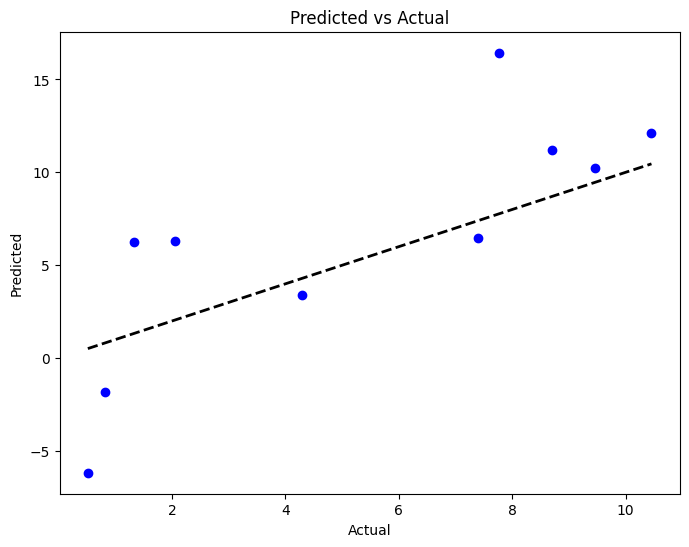

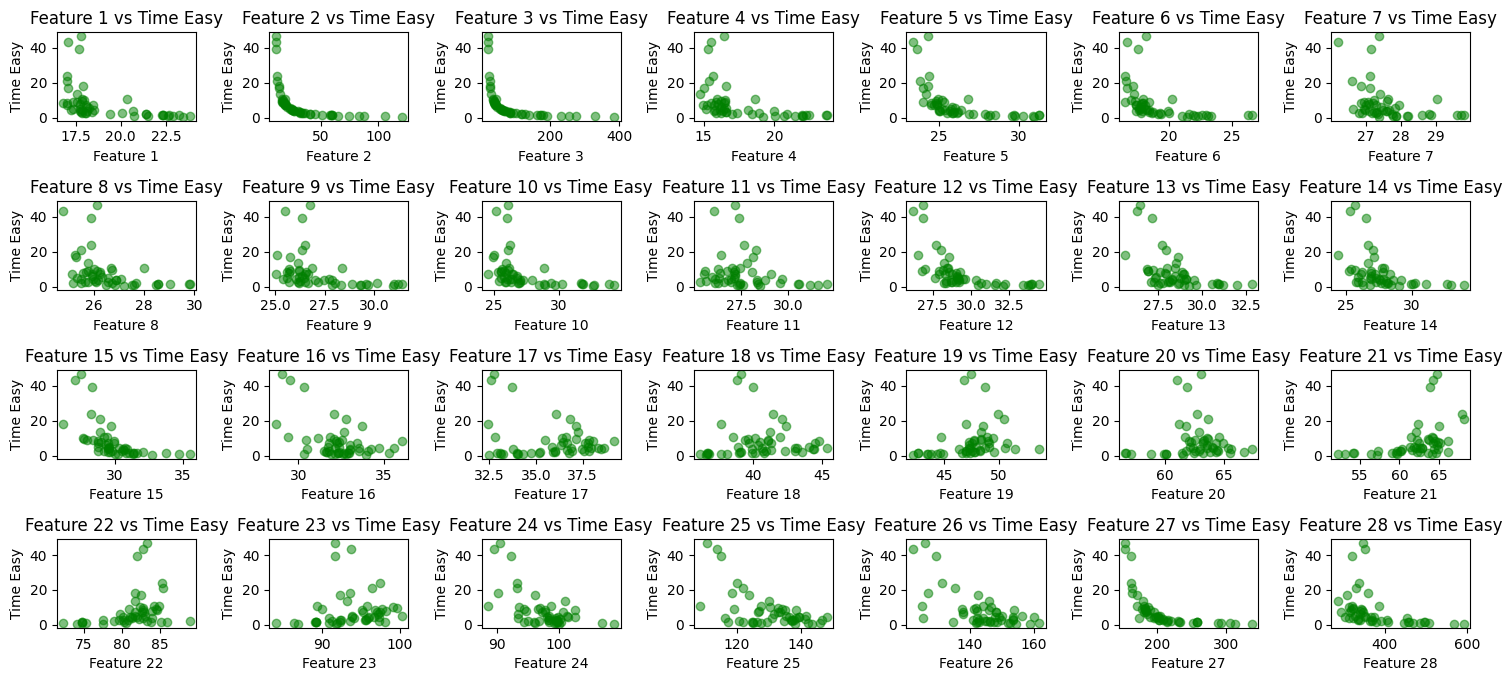

In [15]:
# Reshape all_features_easy to (50, 28*3) = (50, 84)
X = np.asarray(all_features_easy)[:, :, 0].reshape(50, -1)  # Flatten the last two dimensions
y = np.asarray(time_easy)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

# Feature-wise scatter plots
num_features = X.shape[1]
plt.figure(figsize=(15, 20))
for i in range(num_features):
    plt.subplot(12, 7, i + 1)  # Adjust subplot layout based on number of features
    plt.scatter(X[:, i], y, color='green', alpha=0.5)
    plt.xlabel(f'Feature {i+1}')
    plt.ylabel('Time Easy')
    plt.title(f'Feature {i+1} vs Time Easy')
plt.tight_layout()
plt.show()

Mean Squared Error: 391.1696
R² Score: -1.5325


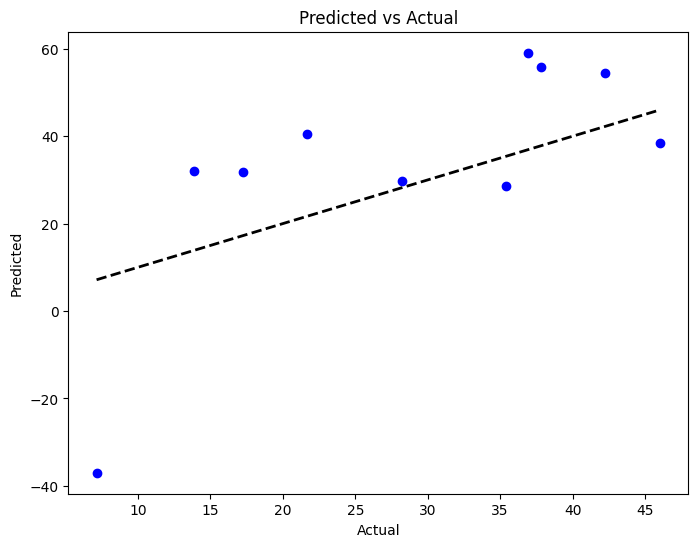

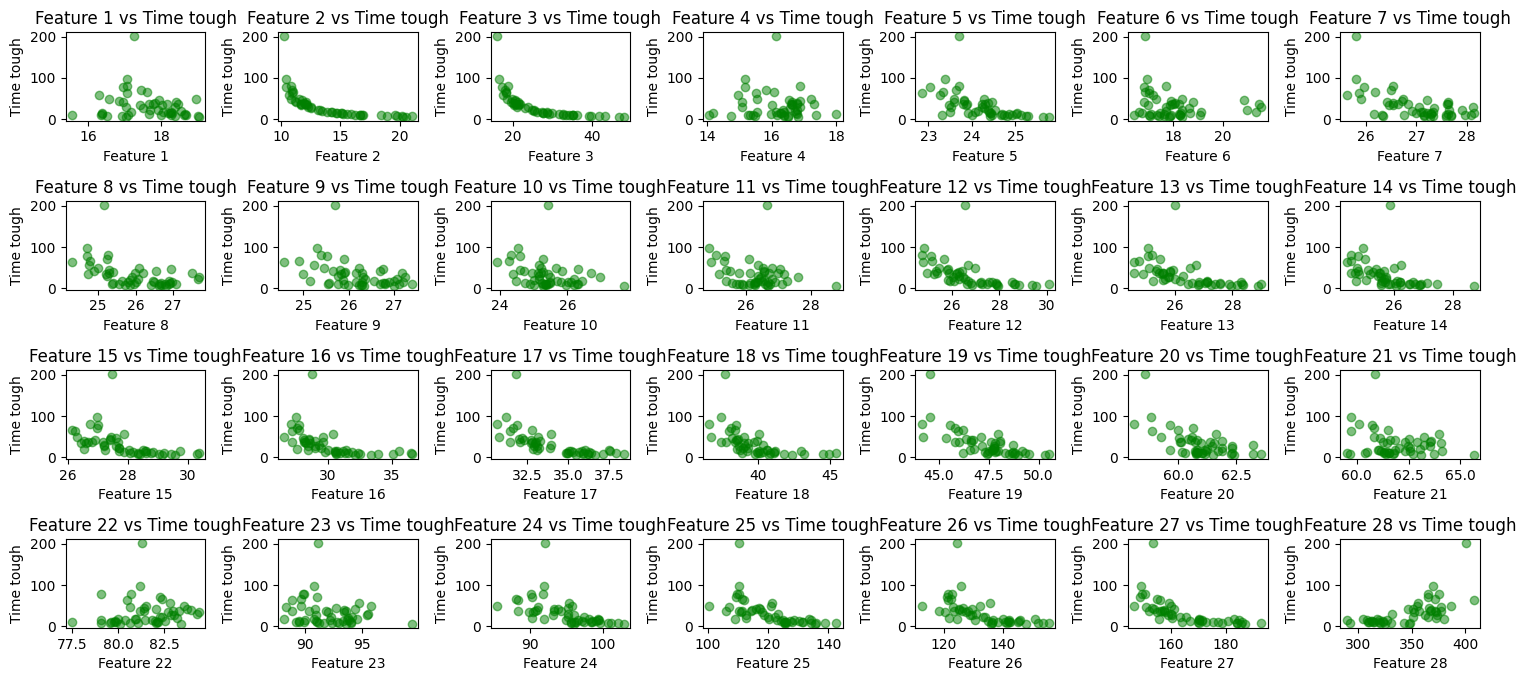

In [16]:
# Reshape all_features_tough to (50, 28*3) = (50, 84)
X = np.asarray(all_features_tough)[:, :, 0].reshape(50, -1)  # Flatten the last two dimensions
y = np.asarray(time_tough)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

# Feature-wise scatter plots
num_features = X.shape[1]
plt.figure(figsize=(15, 20))
for i in range(num_features):
    plt.subplot(12, 7, i + 1)  # Adjust subplot layout based on number of features
    plt.scatter(X[:, i], y, color='green', alpha=0.5)
    plt.xlabel(f'Feature {i+1}')
    plt.ylabel('Time tough')
    plt.title(f'Feature {i+1} vs Time tough')
plt.tight_layout()
plt.show()

Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20



/home/aansh/nnsightusage/nns2env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


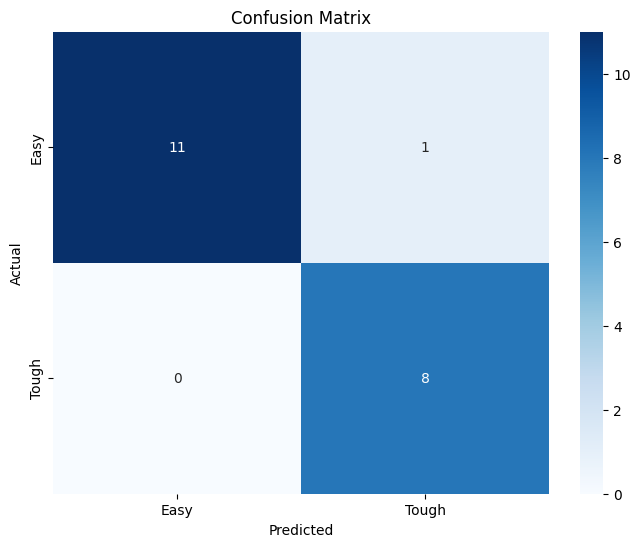

In [17]:
# Combine the features and create labels
X_easy = np.asarray(all_features_easy)[:, :, 0].reshape(50, -1)  # Flatten the last two dimensions
X_tough = np.asarray(all_features_tough)[:, :, 0].reshape(50, -1)  # Flatten the last two dimensions

X = np.vstack((X_easy, X_tough))
y = np.array([0] * 50 + [1] * 50)  # 0 for easy, 1 for tough

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Easy', 'Tough'], yticklabels=['Easy', 'Tough'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

from plotly.subplots import make_subplots
from ipywidgets import widgets
from IPython.display import display

import plotly.graph_objs as go

# Create a dropdown widget for selecting the layer
layer_dropdown = widgets.Dropdown(
    options=[(f'Layer {i+1}', i) for i in range(28)],
    value=0,
    description='Layer:',
)

X_easy = np.asarray(all_features_easy)[:, :, 0]
X_tough = np.asarray(all_features_tough)[:, :, 0]

# Function to update the plot based on the selected layer
def update_plot(layer):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_easy[:, layer], y=time_easy, mode='markers', name='Easy', marker=dict(color='blue')))
    fig.add_trace(go.Scatter(x=X_tough[:, layer], y=time_tough, mode='markers', name='Tough', marker=dict(color='red')))
    fig.update_layout(
        title=f'Layer {layer+1} Mean Norm vs Time',
        xaxis_title=f'Layer {layer+1} Mean Norm',
        yaxis_title='Time',
        legend_title='Type'
    )
    fig.show()

# Display the dropdown and plot
# widgets.interactive(update_plot, layer=layer_dropdown)
# display(layer_dropdown)
# update_plot(layer_dropdown.value)

# Create an interactive plot
interactive_plot = widgets.interactive(update_plot, layer=layer_dropdown)
display(interactive_plot)
# # Reshape all_features_easy and all_features_tough to (50, 28, 3)
# all_features_easy = np.asarray(all_features_easy)
# all_features_tough = np.asarray(all_features_tough)

# # Extract the mean norm features for each layer
# X_easy = all_features_easy[:, :, 0]
# X_tough = all_features_tough[:, :, 0]

# # Plot regression plots for each layer
# plt.figure(figsize=(20, 40))
# for i in range(28):
#     plt.subplot(14, 2, i + 1)
#     plt.scatter(X_easy[:, i], time_easy, color='blue', label='Easy')
#     plt.scatter(X_tough[:, i], time_tough, color='red', label='Tough')
#     plt.xlabel(f'Layer {i+1} Mean Norm')
#     plt.ylabel('Time')
#     plt.title(f'Layer {i+1} Mean Norm vs Time')
#     plt.legend()
# plt.tight_layout()
# plt.show()

interactive(children=(Dropdown(description='Layer:', options=(('Layer 1', 0), ('Layer 2', 1), ('Layer 3', 2), …

##### Detecting Nonlinear Thresholds in Activation Variance

Plotting plots for the above, since the num_tokens generated are a different number, will use different plotting and statistical techniques
1) Individual Plots per Prompt

In [9]:
easy_activation_data = []
for i in tqdm(range(len(easy_questions))):
    act_filename = f"act_prompt_{i+1}.pth"
    act_file_path = os.path.join("/home/aansh/nnsightusage/Data_Math/Simple/Activations", act_filename)
    activations = rearrange_activations(llm, easy_questions[i], act_file_path)
    easy_activation_data.append(activations)

100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


In [11]:
tough_activation_data = []
for i in tqdm(range(len(tough_questions))):
    act_filename = f"act_prompt_{i+1}.pth"
    act_file_path = os.path.join("/home/aansh/nnsightusage/Data_Math/Tough/Activations", act_filename)
    activations = rearrange_activations(llm, tough_questions[i], act_file_path)
    tough_activation_data.append(activations)

100%|██████████| 50/50 [03:03<00:00,  3.66s/it]


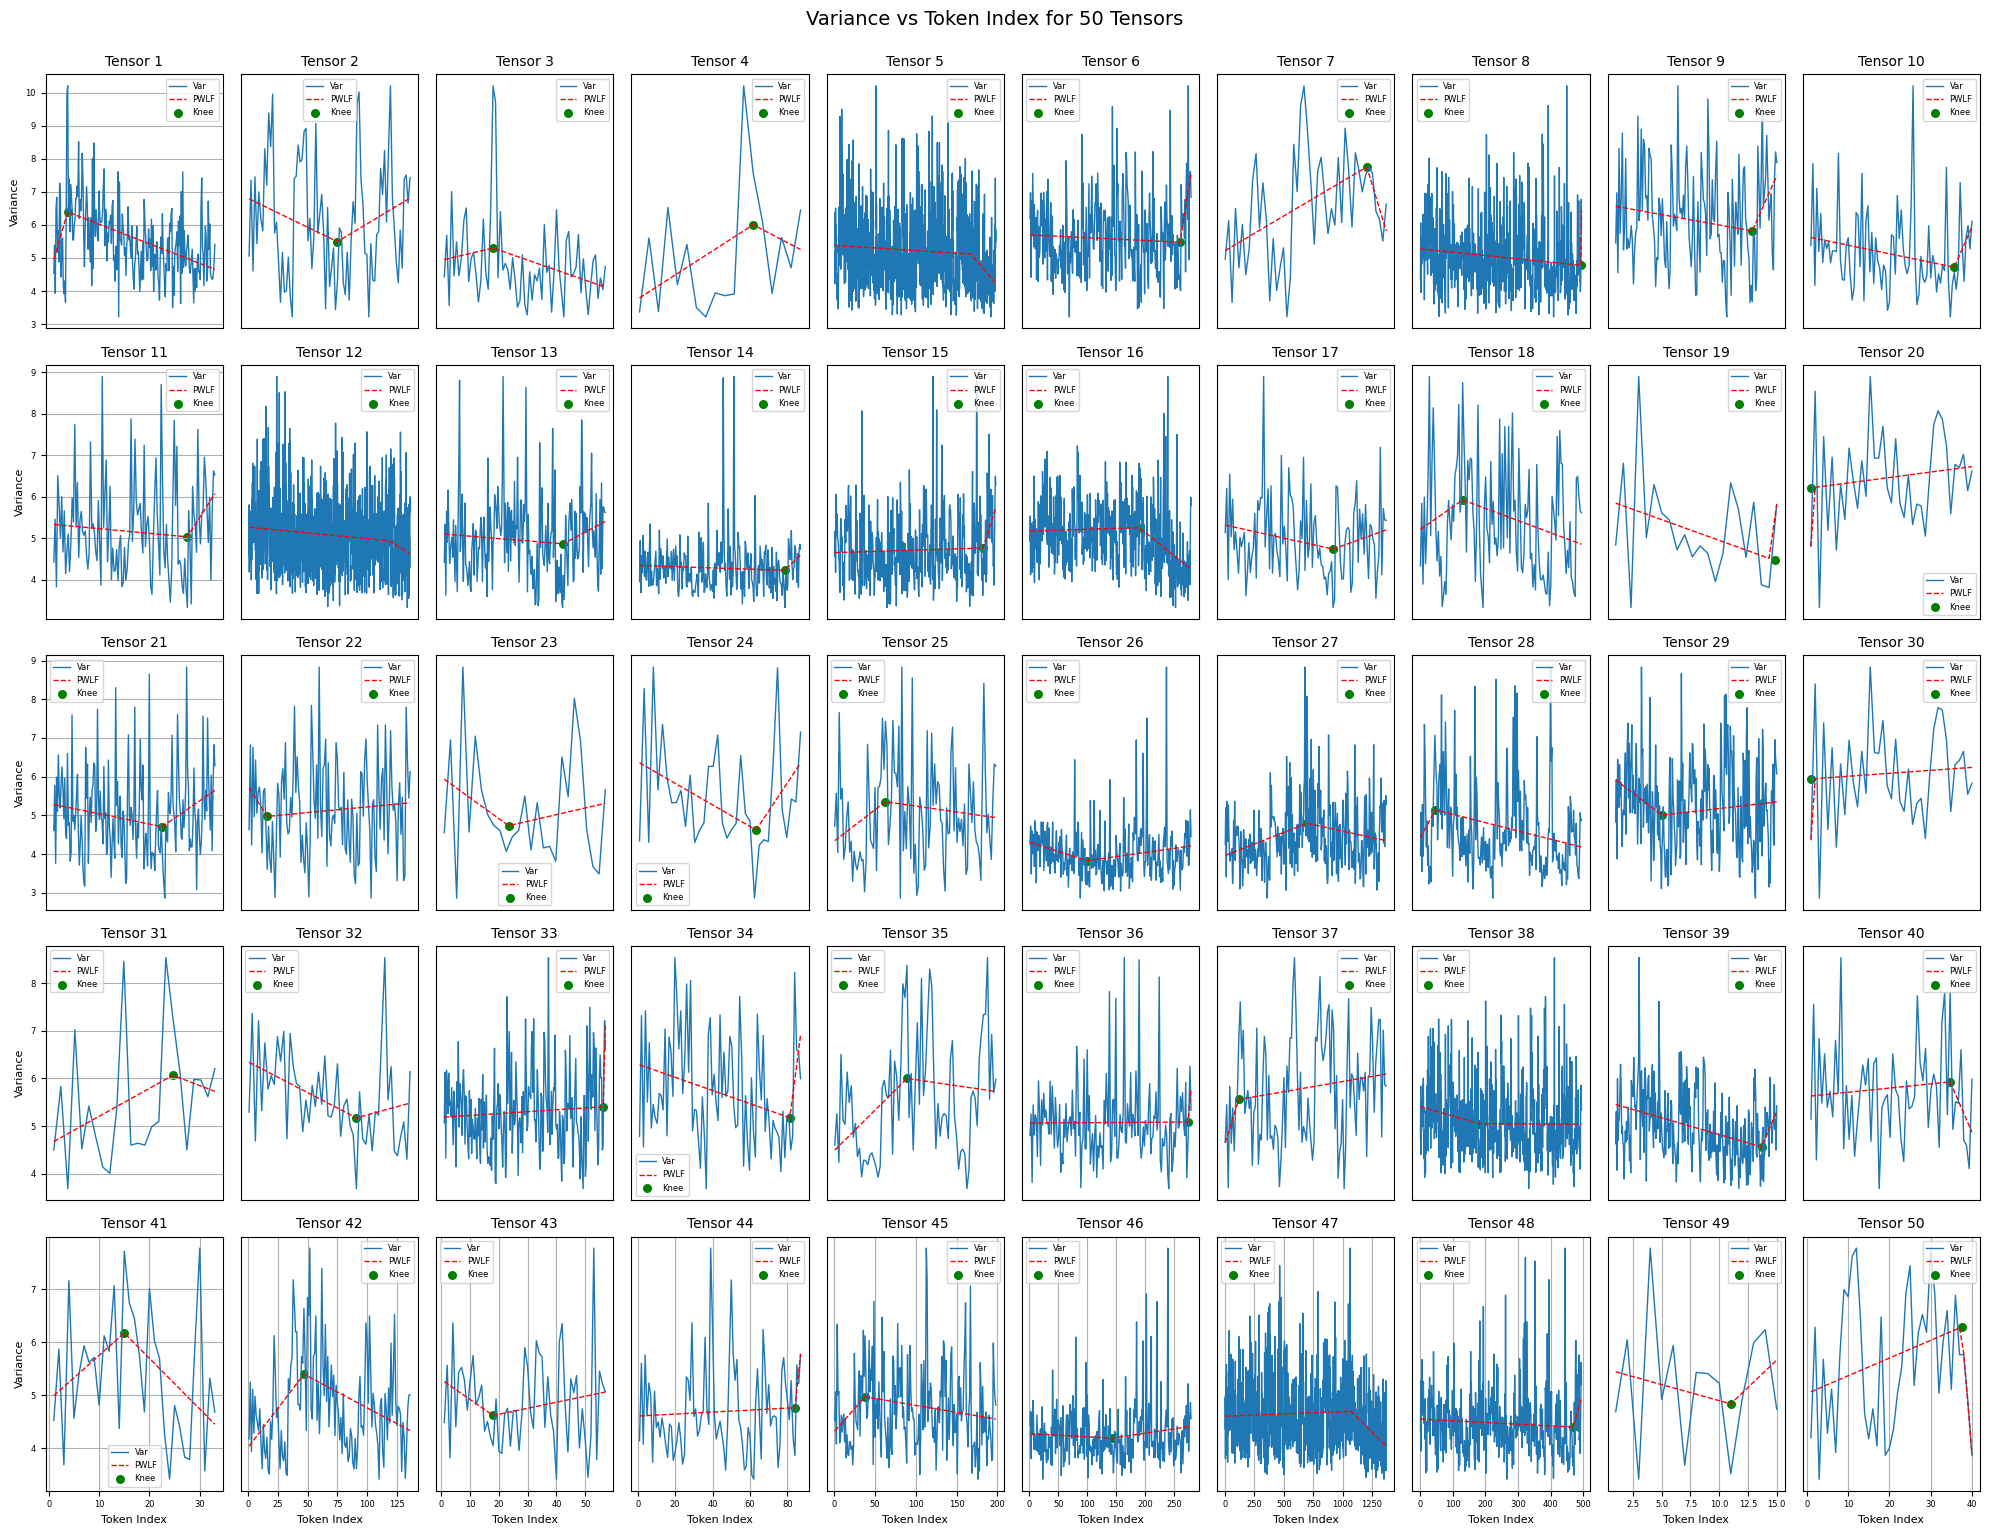

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pwlf

# 1. Plot Variance vs Token Index (modified to start token index from 1 for plotting)
def calculate_variance_curve(tensor):
    """
    Calculates the variance and returns token indices starting from 1 for plotting.

    Args:
        tensor: Tensor of shape (num_layers, num_tokens, d_model)

    Returns:
        token_indices: numpy array of token indices (starting from 1)
        variances: numpy array of variances for each token index
    """
    num_layers, num_tokens, d_model = tensor.shape
    variances = []
    for token_index in range(1, num_tokens):
        token_tensor = tensor[:, token_index, :]
        variance = torch.var(token_tensor.flatten(), unbiased=False).item()
        variances.append(variance)
    return np.arange(1, num_tokens), np.array(variances) # Token indices start from 1


# 2. Fit Piecewise Linear Regression and 3. Identify Knee Point (same as before)
def fit_piecewise_linear_regression_and_knee(token_indices, variances):
    pw_model = pwlf.PiecewiseLinFit(token_indices, variances)
    res = pw_model.fit(2)

    if pw_model.n_segments > 1:
        knee_point_index = pw_model.fit_breaks[1]
        return pw_model, knee_point_index
    else:
        return pw_model, None


# --- Subplots ---
num_rows = 5
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15)) # Adjust figsize as needed
axes = axes.flatten() # Flatten to easily iterate through subplots

for i, tensor in enumerate(easy_activation_data):
    token_indices, variances = calculate_variance_curve(tensor)

    ax = axes[i] # Get the current subplot

    # --- Plotting Variance Curve on Subplot ---
    ax.plot(token_indices, variances, label=f'Var', linewidth=1) # Shorter label
    ax.set_title(f'Tensor {i+1}', fontsize=10) # Smaller title
    ax.grid(True)

    # --- Piecewise Linear Regression and Knee Point Identification ---
    pw_model, knee_point_index = fit_piecewise_linear_regression_and_knee(token_indices, variances)

    if knee_point_index is not None:
        y_hat = pw_model.predict(token_indices)
        ax.plot(token_indices, y_hat, color='red', linestyle='--', linewidth=1, label='PWLF') # Shorter label
        ax.scatter(knee_point_index, pw_model.predict(np.array([knee_point_index]))[0], color='green', marker='o', s=30, label='Knee') # Smaller marker

    # Remove x and y axis labels for inner subplots to reduce clutter
    if i >= (num_rows - 1) * num_cols: # Only label x-axis on the last row
        ax.set_xlabel('Token Index', fontsize=8)
    else:
        ax.set_xticks([]) # Remove x-ticks for other rows

    if i % num_cols == 0: # Only label y-axis on the first column
        ax.set_ylabel('Variance', fontsize=8)
    else:
        ax.set_yticks([]) # Remove y-ticks for other columns


    ax.tick_params(axis='both', which='major', labelsize=6) # Smaller tick labels
    ax.legend(fontsize=6) # Smaller legend

# If you have fewer than num_rows * num_cols tensors, remove unused subplots
for j in range(len(easy_activation_data), num_rows * num_cols):
    fig.delaxes(axes[j])


plt.tight_layout() # Adjust layout for subplots
plt.suptitle('Variance vs Token Index for 50 Tensors', fontsize=14, y=1.02) # Overall figure title
plt.show()

In [ ]:
# tough_activation_data = []
# for i in tqdm(range(len(tough_questions))):
#     act_filename = f"act_prompt_{i+1}.pth"
#     act_file_path = os.path.join("/home/aansh/nnsightusage/Data_Math/Tough/Activations", act_filename)
#     activations = rearrange_activations(llm, tough_questions[i], act_file_path)
#     tough_activation_data.append(activations)

100%|██████████| 50/50 [02:42<00:00,  3.26s/it]


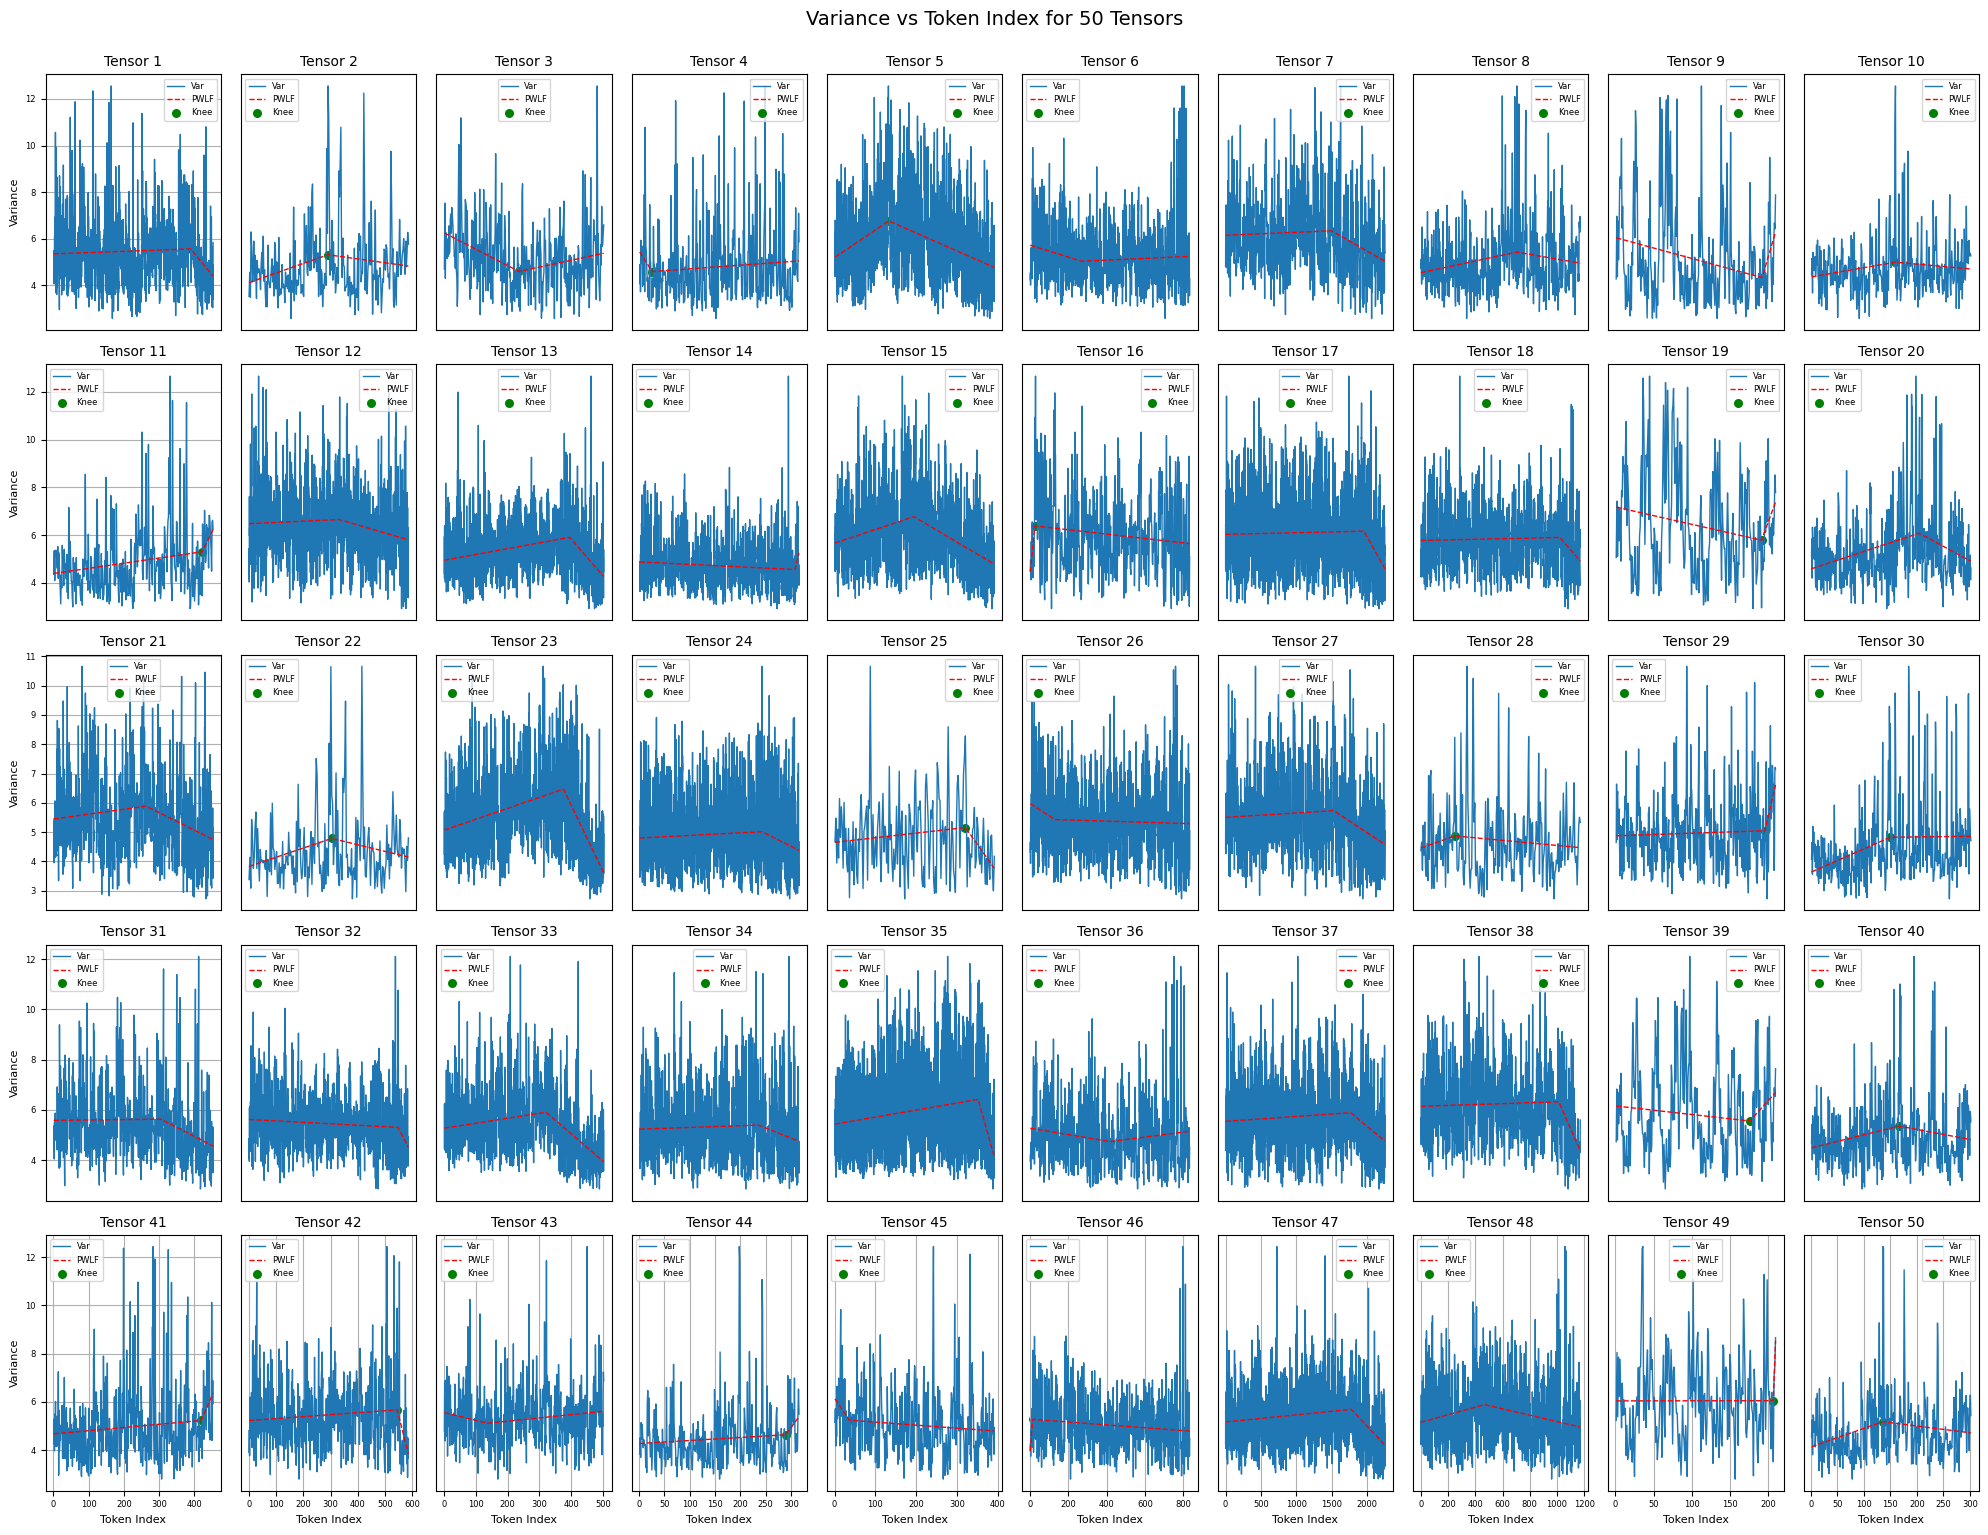

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pwlf

# 1. Plot Variance vs Token Index (modified to start token index from 1 for plotting)
def calculate_variance_curve(tensor):
    """
    Calculates the variance and returns token indices starting from 1 for plotting.

    Args:
        tensor: Tensor of shape (num_layers, num_tokens, d_model)

    Returns:
        token_indices: numpy array of token indices (starting from 1)
        variances: numpy array of variances for each token index
    """
    num_layers, num_tokens, d_model = tensor.shape
    variances = []
    for token_index in range(1, num_tokens):
        token_tensor = tensor[:, token_index, :]
        variance = torch.var(token_tensor.flatten(), unbiased=False).item()
        variances.append(variance)
    return np.arange(1, num_tokens), np.array(variances) # Token indices start from 1


# 2. Fit Piecewise Linear Regression and 3. Identify Knee Point (same as before)
def fit_piecewise_linear_regression_and_knee(token_indices, variances):
    pw_model = pwlf.PiecewiseLinFit(token_indices, variances)
    res = pw_model.fit(2)

    if pw_model.n_segments > 1:
        knee_point_index = pw_model.fit_breaks[1]
        return pw_model, knee_point_index
    else:
        return pw_model, None


# --- Subplots ---
num_rows = 5
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15)) # Adjust figsize as needed
axes = axes.flatten() # Flatten to easily iterate through subplots

for i, tensor in enumerate(tough_activation_data):
    token_indices, variances = calculate_variance_curve(tensor)

    ax = axes[i] # Get the current subplot

    # --- Plotting Variance Curve on Subplot ---
    ax.plot(token_indices, variances, label=f'Var', linewidth=1) # Shorter label
    ax.set_title(f'Tensor {i+1}', fontsize=10) # Smaller title
    ax.grid(True)

    # --- Piecewise Linear Regression and Knee Point Identification ---
    pw_model, knee_point_index = fit_piecewise_linear_regression_and_knee(token_indices, variances)

    if knee_point_index is not None:
        y_hat = pw_model.predict(token_indices)
        ax.plot(token_indices, y_hat, color='red', linestyle='--', linewidth=1, label='PWLF') # Shorter label
        ax.scatter(knee_point_index, pw_model.predict(np.array([knee_point_index]))[0], color='green', marker='o', s=30, label='Knee') # Smaller marker

    # Remove x and y axis labels for inner subplots to reduce clutter
    if i >= (num_rows - 1) * num_cols: # Only label x-axis on the last row
        ax.set_xlabel('Token Index', fontsize=8)
    else:
        ax.set_xticks([]) # Remove x-ticks for other rows

    if i % num_cols == 0: # Only label y-axis on the first column
        ax.set_ylabel('Variance', fontsize=8)
    else:
        ax.set_yticks([]) # Remove y-ticks for other columns


    ax.tick_params(axis='both', which='major', labelsize=6) # Smaller tick labels
    ax.legend(fontsize=6) # Smaller legend

# If you have fewer than num_rows * num_cols tensors, remove unused subplots
for j in range(len(tough_activation_data), num_rows * num_cols):
    fig.delaxes(axes[j])


plt.tight_layout() # Adjust layout for subplots
plt.suptitle('Variance vs Token Index for 50 Tensors', fontsize=14, y=1.02) # Overall figure title
plt.show()

2) Normalized plots for the same

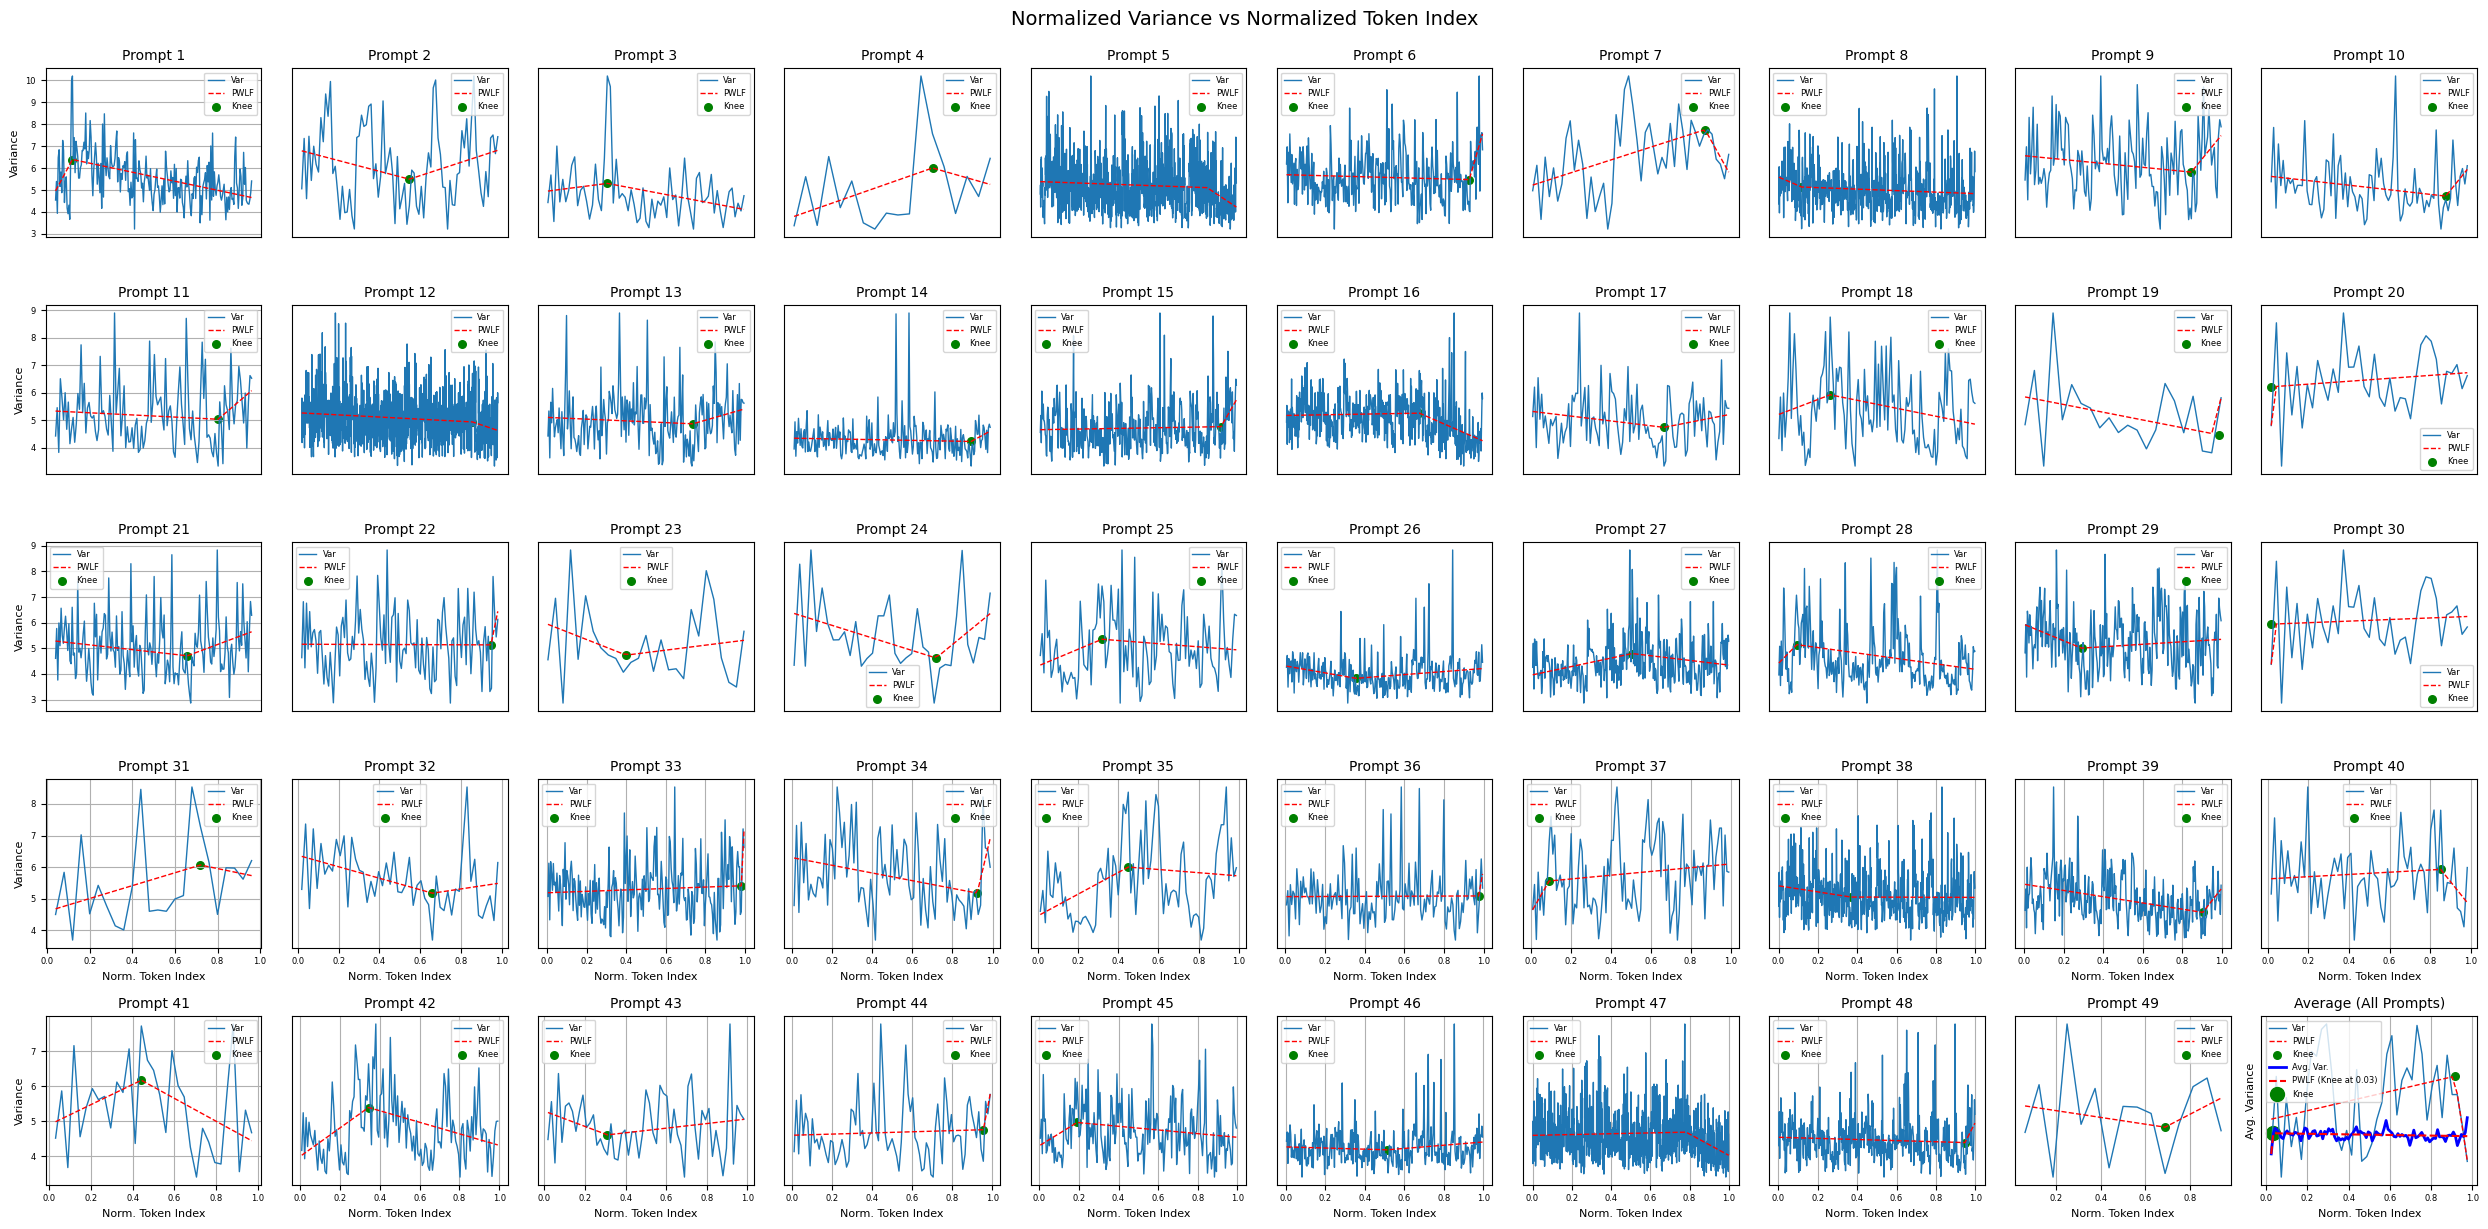

Average Variance Curve: Knee point identified at normalized token index: 0.03


In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pwlf

# 1. Calculate Variance Curve with Normalized Token Index (same as before)
def calculate_variance_curve_normalized_index(tensor):
    num_layers, num_tokens, d_model = tensor.shape
    variances = []
    for token_index in range(1, num_tokens):
        token_tensor = tensor[:, token_index, :]
        variance = torch.var(token_tensor.flatten(), unbiased=False).item()
        variances.append(variance)
    normalized_token_indices = (np.arange(1, num_tokens) / num_tokens)
    return normalized_token_indices, np.array(variances)

# 2. Fit Piecewise Linear Regression and 3. Identify Knee Point (same as before)
def fit_piecewise_linear_regression_and_knee(token_indices, variances):
    pw_model = pwlf.PiecewiseLinFit(token_indices, variances)
    res = pw_model.fit(2)

    if pw_model.n_segments > 1:
        knee_point_index = pw_model.fit_breaks[1]
        return pw_model, knee_point_index
    else:
        return pw_model, None

# --- Subplots for Individual Normalized Variance Curves and Average ---
num_rows = 5 # Increased rows to accommodate average plot at the end
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12)) # Adjusted figsize
axes = axes.flatten()

# --- Calculate Average Normalized Variance Curve Data BEFORE plotting subplots ---
all_normalized_variances = []
max_normalized_index_len = 100

for tensor in easy_activation_data:
    normalized_token_indices, variances = calculate_variance_curve_normalized_index(tensor)
    interp_indices = np.linspace(normalized_token_indices.min(), normalized_token_indices.max(), max_normalized_index_len)
    interp_variances = np.interp(interp_indices, normalized_token_indices, variances)
    all_normalized_variances.append(interp_variances)

average_variances = np.mean(all_normalized_variances, axis=0)
average_normalized_indices = interp_indices

# --- Plotting Individual Normalized Variance Curves in Subplots ---
for i, tensor in enumerate(easy_activation_data):
    normalized_token_indices, variances = calculate_variance_curve_normalized_index(tensor)

    ax = axes[i]

    ax.plot(normalized_token_indices, variances, label=f'Var', linewidth=1)
    ax.set_title(f'Prompt {i+1}', fontsize=10)
    ax.grid(True)

    pw_model, knee_point_index = fit_piecewise_linear_regression_and_knee(normalized_token_indices, variances)
    if knee_point_index is not None:
        y_hat = pw_model.predict(normalized_token_indices)
        ax.plot(normalized_token_indices, y_hat, color='red', linestyle='--', linewidth=1, label='PWLF')
        ax.scatter(knee_point_index, pw_model.predict(np.array([knee_point_index]))[0], color='green', marker='o', s=30, label='Knee')

    if i >= (num_rows - 1) * num_cols - num_cols: # Label x-axis on the second to last row now
        ax.set_xlabel('Norm. Token Index', fontsize=8)
    else:
        ax.set_xticks([])

    if i % num_cols == 0:
        ax.set_ylabel('Variance', fontsize=8)
    else:
        ax.set_yticks([])

    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6)


# --- Plot Average Normalized Variance Curve in the LAST Subplot ---
average_plot_index = num_rows * num_cols -1 # Last subplot index
ax_avg = axes[average_plot_index]

ax_avg.plot(average_normalized_indices, average_variances, label='Avg. Var.', color='blue', linewidth=2) # Shorter label
ax_avg.set_xlabel('Norm. Token Index', fontsize=8) # x-axis label for average plot
ax_avg.set_ylabel('Avg. Variance', fontsize=8) # y-axis label for average plot
ax_avg.set_title('Average (All Prompts)', fontsize=10) # Title for average plot
ax_avg.grid(True)

pw_model_avg, knee_point_index_avg = fit_piecewise_linear_regression_and_knee(average_normalized_indices, average_variances)
if knee_point_index_avg is not None:
    y_hat_avg = pw_model_avg.predict(average_normalized_indices)
    ax_avg.plot(average_normalized_indices, y_hat_avg, color='red', linestyle='--', linewidth=1.5, label=f'PWLF (Knee at {knee_point_index_avg:.2f})')
    ax_avg.scatter(knee_point_index_avg, pw_model_avg.predict(np.array([knee_point_index_avg]))[0], color='green', marker='o', s=100, label='Knee')

ax_avg.tick_params(axis='both', which='major', labelsize=6)
ax_avg.legend(fontsize=6)


# Remove unused subplots (if any remain before the average plot)
for j in range(len(easy_activation_data), average_plot_index): # Stop before the average plot index
    fig.delaxes(axes[j])
if len(easy_activation_data) < average_plot_index: # If average plot subplot is not the immediate next after last data plot
    fig.delaxes(axes[average_plot_index - 1]) # remove the subplot before average plot if it's empty


plt.tight_layout()
plt.suptitle('Normalized Variance vs Normalized Token Index', fontsize=14, y=1.02)
plt.show()

if knee_point_index_avg is not None:
    print(f"Average Variance Curve: Knee point identified at normalized token index: {knee_point_index_avg:.2f}")
else:
    print(f"Average Variance Curve: Piecewise linear fit did not identify a clear knee point.")

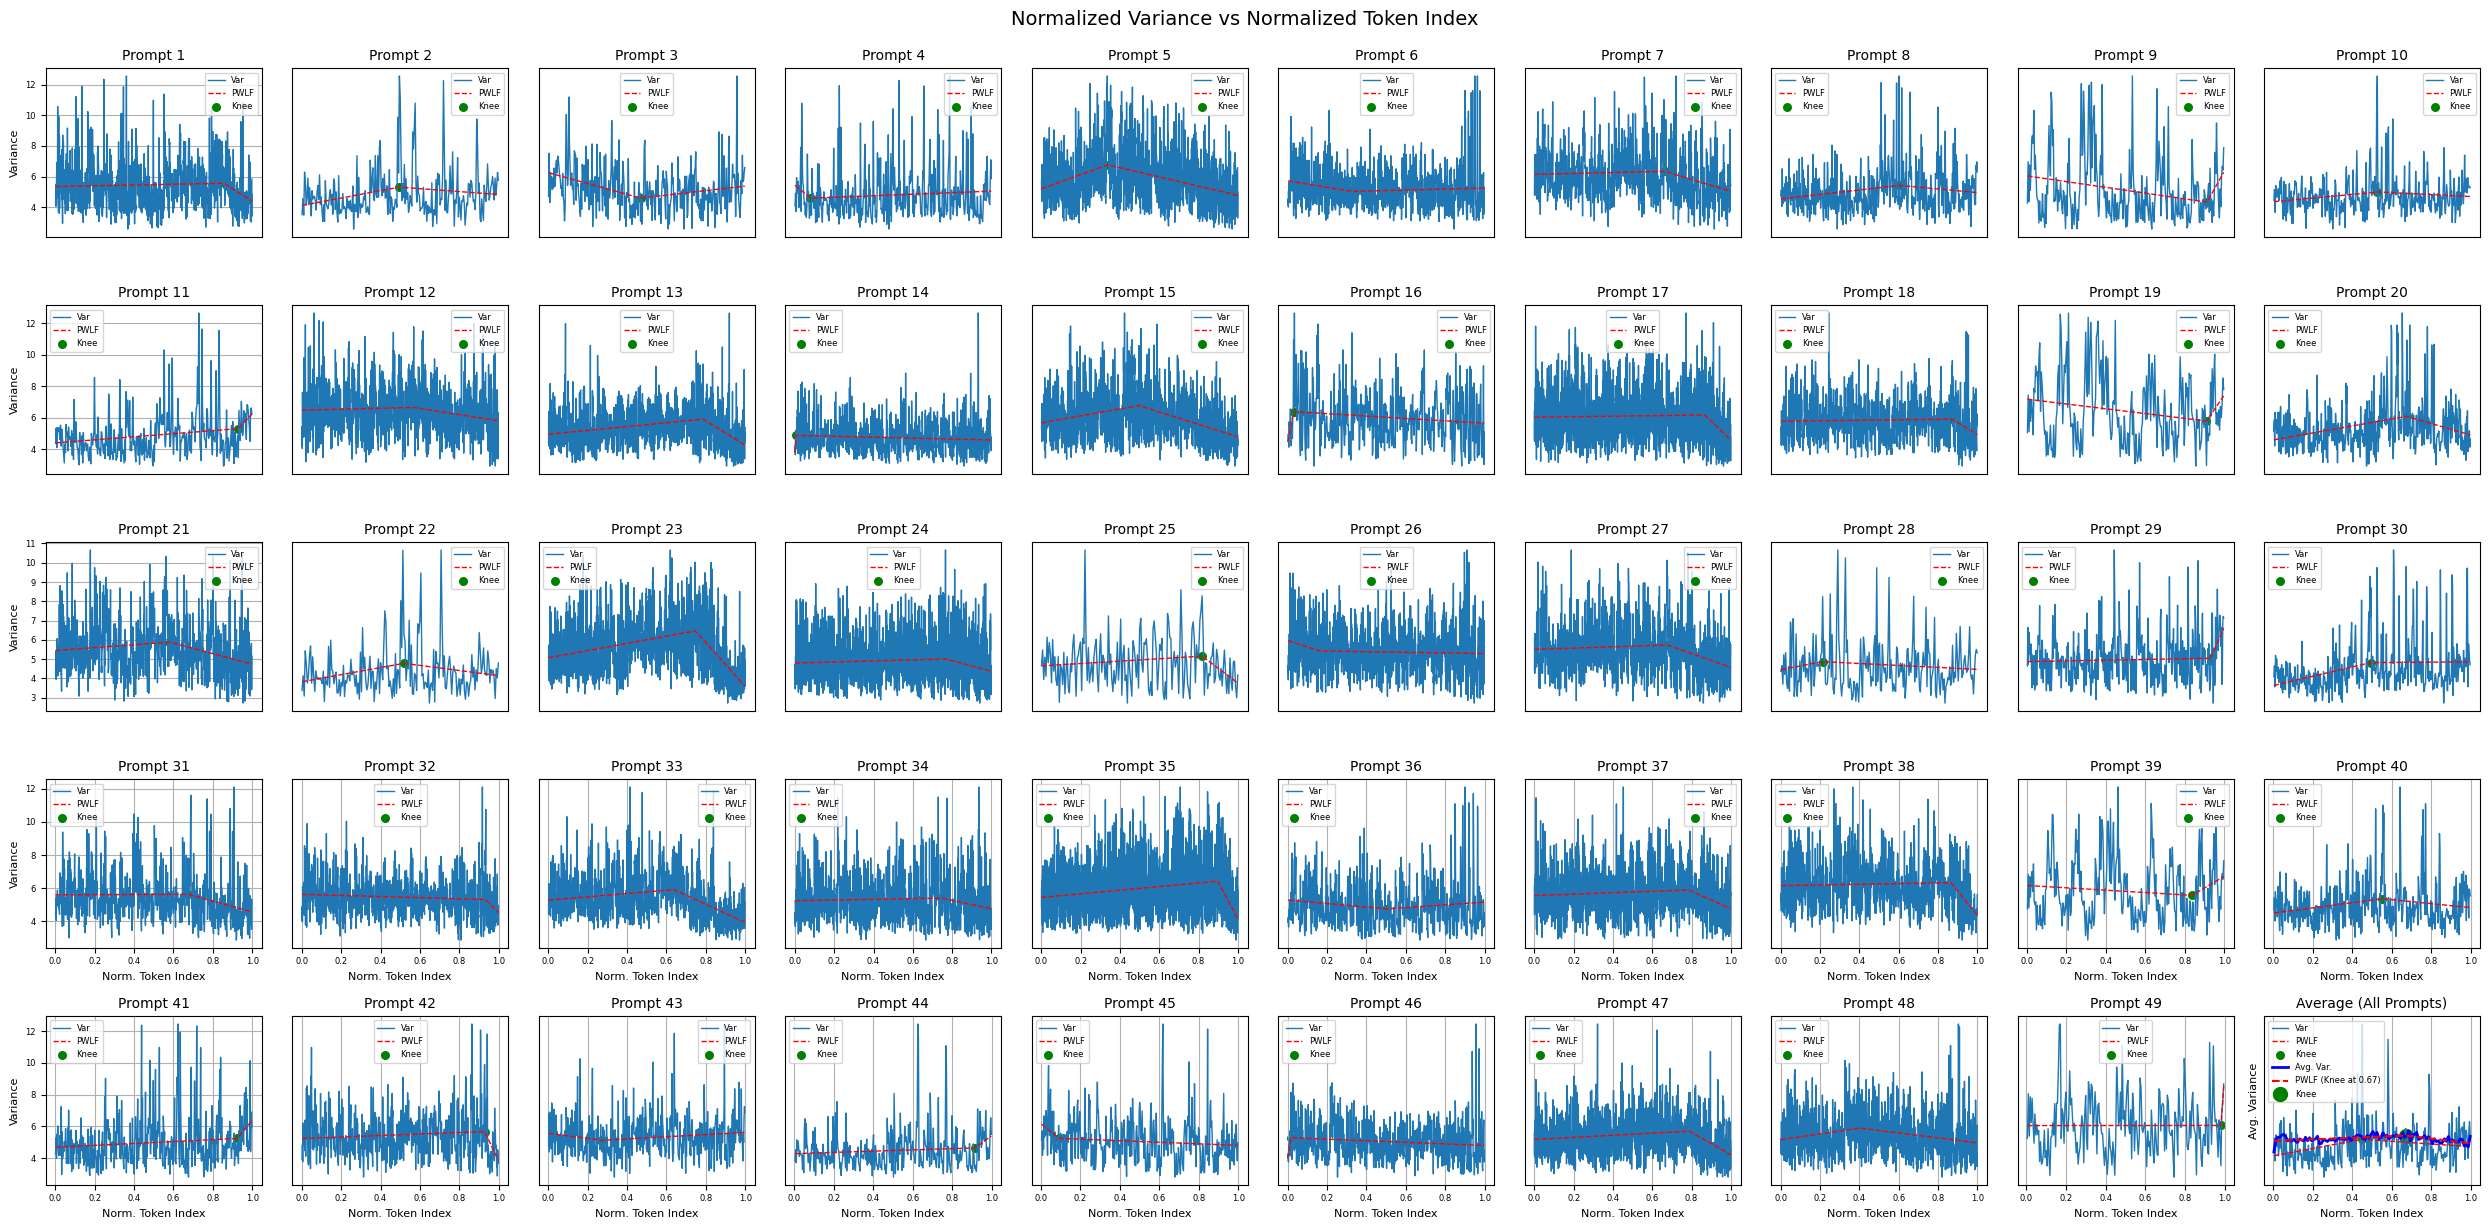

Average Variance Curve: Knee point identified at normalized token index: 0.67


In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pwlf

# 1. Calculate Variance Curve with Normalized Token Index (same as before)
def calculate_variance_curve_normalized_index(tensor):
    num_layers, num_tokens, d_model = tensor.shape
    variances = []
    for token_index in range(1, num_tokens):
        token_tensor = tensor[:, token_index, :]
        variance = torch.var(token_tensor.flatten(), unbiased=False).item()
        variances.append(variance)
    normalized_token_indices = (np.arange(1, num_tokens) / num_tokens)
    return normalized_token_indices, np.array(variances)

# 2. Fit Piecewise Linear Regression and 3. Identify Knee Point (same as before)
def fit_piecewise_linear_regression_and_knee(token_indices, variances):
    pw_model = pwlf.PiecewiseLinFit(token_indices, variances)
    res = pw_model.fit(2)

    if pw_model.n_segments > 1:
        knee_point_index = pw_model.fit_breaks[1]
        return pw_model, knee_point_index
    else:
        return pw_model, None

# --- Subplots for Individual Normalized Variance Curves and Average ---
num_rows = 5 # Increased rows to accommodate average plot at the end
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 12)) # Adjusted figsize
axes = axes.flatten()

# --- Calculate Average Normalized Variance Curve Data BEFORE plotting subplots ---
all_normalized_variances = []
max_normalized_index_len = 100

for tensor in tough_activation_data:
    normalized_token_indices, variances = calculate_variance_curve_normalized_index(tensor)
    interp_indices = np.linspace(normalized_token_indices.min(), normalized_token_indices.max(), max_normalized_index_len)
    interp_variances = np.interp(interp_indices, normalized_token_indices, variances)
    all_normalized_variances.append(interp_variances)

average_variances = np.mean(all_normalized_variances, axis=0)
average_normalized_indices = interp_indices

# --- Plotting Individual Normalized Variance Curves in Subplots ---
for i, tensor in enumerate(tough_activation_data):
    normalized_token_indices, variances = calculate_variance_curve_normalized_index(tensor)

    ax = axes[i]

    ax.plot(normalized_token_indices, variances, label=f'Var', linewidth=1)
    ax.set_title(f'Prompt {i+1}', fontsize=10)
    ax.grid(True)

    pw_model, knee_point_index = fit_piecewise_linear_regression_and_knee(normalized_token_indices, variances)
    if knee_point_index is not None:
        y_hat = pw_model.predict(normalized_token_indices)
        ax.plot(normalized_token_indices, y_hat, color='red', linestyle='--', linewidth=1, label='PWLF')
        ax.scatter(knee_point_index, pw_model.predict(np.array([knee_point_index]))[0], color='green', marker='o', s=30, label='Knee')

    if i >= (num_rows - 1) * num_cols - num_cols: # Label x-axis on the second to last row now
        ax.set_xlabel('Norm. Token Index', fontsize=8)
    else:
        ax.set_xticks([])

    if i % num_cols == 0:
        ax.set_ylabel('Variance', fontsize=8)
    else:
        ax.set_yticks([])

    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6)


# --- Plot Average Normalized Variance Curve in the LAST Subplot ---
average_plot_index = num_rows * num_cols -1 # Last subplot index
ax_avg = axes[average_plot_index]

ax_avg.plot(average_normalized_indices, average_variances, label='Avg. Var.', color='blue', linewidth=2) # Shorter label
ax_avg.set_xlabel('Norm. Token Index', fontsize=8) # x-axis label for average plot
ax_avg.set_ylabel('Avg. Variance', fontsize=8) # y-axis label for average plot
ax_avg.set_title('Average (All Prompts)', fontsize=10) # Title for average plot
ax_avg.grid(True)

pw_model_avg, knee_point_index_avg = fit_piecewise_linear_regression_and_knee(average_normalized_indices, average_variances)
if knee_point_index_avg is not None:
    y_hat_avg = pw_model_avg.predict(average_normalized_indices)
    ax_avg.plot(average_normalized_indices, y_hat_avg, color='red', linestyle='--', linewidth=1.5, label=f'PWLF (Knee at {knee_point_index_avg:.2f})')
    ax_avg.scatter(knee_point_index_avg, pw_model_avg.predict(np.array([knee_point_index_avg]))[0], color='green', marker='o', s=100, label='Knee')

ax_avg.tick_params(axis='both', which='major', labelsize=6)
ax_avg.legend(fontsize=6)


# Remove unused subplots (if any remain before the average plot)
for j in range(len(tough_activation_data), average_plot_index): # Stop before the average plot index
    fig.delaxes(axes[j])
if len(tough_activation_data) < average_plot_index: # If average plot subplot is not the immediate next after last data plot
    fig.delaxes(axes[average_plot_index - 1]) # remove the subplot before average plot if it's empty


plt.tight_layout()
plt.suptitle('Normalized Variance vs Normalized Token Index', fontsize=14, y=1.02)
plt.show()

if knee_point_index_avg is not None:
    print(f"Average Variance Curve: Knee point identified at normalized token index: {knee_point_index_avg:.2f}")
else:
    print(f"Average Variance Curve: Piecewise linear fit did not identify a clear knee point.")

## Experiment 2: Uncovering Discrete Phase Transitions in Reasoning
1) Per prompt analysis - Manual Inspection

Processing Prompt 1...


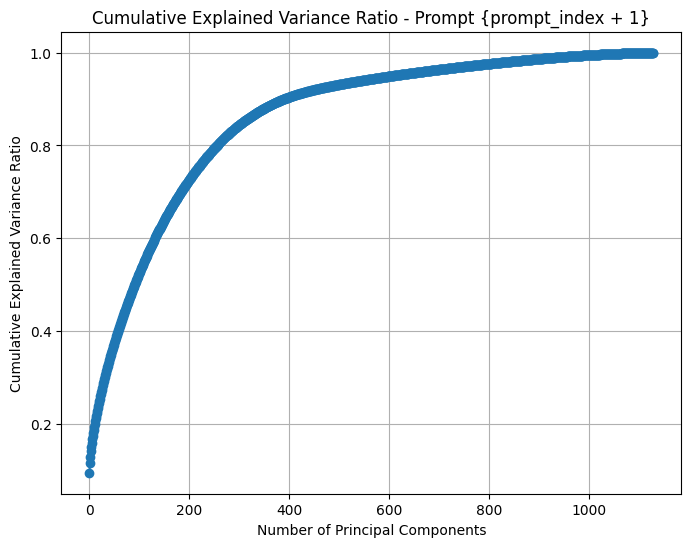

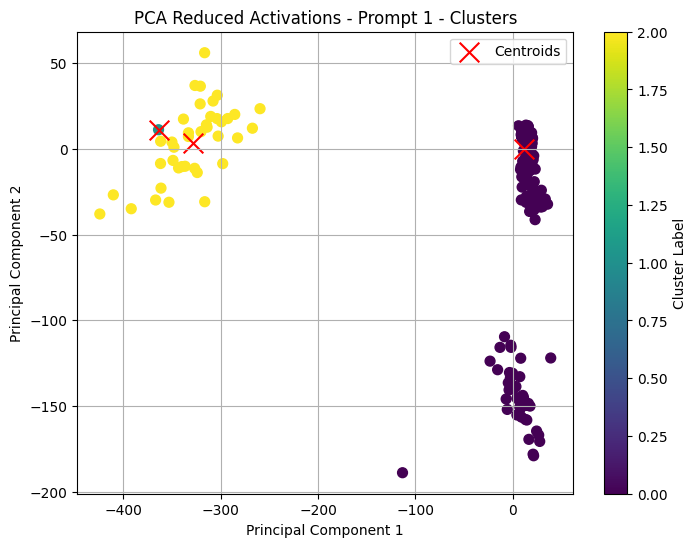

Prompt 1: Identified 3 phase transitions at token indices: [1090, 1121, 1122]
Cluster labels for Prompt 1: [0 0 0 ... 2 2 2]
Processing complete. Manually inspect the outputs and CoT texts for each prompt.


In [13]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # or GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ... (load your tough_activation_data - get ONE tensor at a time for manual inspection) ...

for prompt_index, tensor in enumerate(tough_activation_data):
    if(prompt_index == 1): break
    # Process each prompt individually
    print(f"Processing Prompt {prompt_index + 1}...")

    # Stage 1: PCA (Per Prompt)
    num_layers, num_tokens, d_model = tensor.shape
    X_prompt = tensor.reshape(num_tokens, num_layers * d_model).numpy() # Flatten activations for this prompt

    scaler_prompt = StandardScaler()
    X_prompt_scaled = scaler_prompt.fit_transform(X_prompt)
    pca_prompt = PCA() # Or choose n_components based on variance explained
    pca_prompt.fit(X_prompt_scaled)
    cumulative_variance_ratio_prompt = np.cumsum(pca_prompt.explained_variance_ratio_)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance_ratio_prompt, marker='o')
    plt.title('Cumulative Explained Variance Ratio - Prompt {prompt_index + 1}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.show()
    # ... (Plot cumulative_variance_ratio_prompt to choose n_components visually) ...
    n_components_prompt = 300 # Example: Choose based on elbow plot

    pca_prompt = PCA(n_components=n_components_prompt)
    X_prompt_reduced = pca_prompt.fit_transform(X_prompt_scaled)

    # Stage 2: Clustering (Per Prompt - KMeans example)
    silhouette_scores_prompt = []
    for n_clusters in range(2, 7): # Test a smaller range for each prompt
        kmeans_prompt = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        cluster_labels_prompt_temp = kmeans_prompt.fit_predict(X_prompt_reduced)
        silhouette_avg_prompt = silhouette_score(X_prompt_reduced, cluster_labels_prompt_temp)
        silhouette_scores_prompt.append(silhouette_avg_prompt)
    # ... (Plot silhouette_scores_prompt to choose optimal_k_prompt visually) ...
    optimal_k_prompt = 3 # Example: Choose based on silhouette plot

    kmeans_prompt = KMeans(n_clusters=optimal_k_prompt, init='k-means++', n_init=10, random_state=42)
    cluster_labels_prompt = kmeans_prompt.fit_predict(X_prompt_reduced)
    cluster_centroids_prompt = kmeans_prompt.cluster_centers_

    # Stage 3: Phase Transition Identification
    transition_indices_prompt = []
    for token_index in range(1, num_tokens):
        if cluster_labels_prompt[token_index] != cluster_labels_prompt[token_index-1]:
            transition_indices_prompt.append(token_index)

    # Stage 4: Visualization (for current prompt)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_prompt_reduced[:, 0], X_prompt_reduced[:, 1], c=cluster_labels_prompt, cmap='viridis', s=50) # PCA components 1 & 2
    plt.scatter(cluster_centroids_prompt[:, 0], cluster_centroids_prompt[:, 1], marker='x', s=200, color='red', label='Centroids')
    plt.title(f'PCA Reduced Activations - Prompt {prompt_index + 1} - Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster Label') # Add colorbar for cluster labels
    plt.grid(True)
    plt.show()

    print(f"Prompt {prompt_index + 1}: Identified {len(transition_indices_prompt)} phase transitions at token indices: {transition_indices_prompt}")
    print(f"Cluster labels for Prompt {prompt_index + 1}: {cluster_labels_prompt}")

    # Stage 5: Manual Inspection - **YOU NEED TO DO THIS MANUALLY AFTER RUNNING THE CODE**
    # - Examine the CoT output text for Prompt {prompt_index + 1}.
    # - Manually segment and label phases based on cluster changes and text content.
    # - Evaluate if the identified phases are meaningful.


print("Processing complete. Manually inspect the outputs and CoT texts for each prompt.")

In [68]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # or GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os  # For directory creation
from transformers import AutoTokenizer # Or your tokenizer

# --- Assuming you have your tough_activation_data (activation tensors) and prompt_list (list of strings) ---
# --- Sample prompt_list for demonstration (replace with your actual prompt_list) ---
prompt_list = []
answers_dir_path = "/home/aansh/nnsightusage/Data_Math/Tough/Answers"
for i in range(50):
    answer_filename = f"ans_prompt_{i+1}.txt"
    with open(os.path.join(answers_dir_path, answer_filename), "r", encoding="utf-8") as f:
        answer_text = f.read().strip()
        prompt_list.append(answer_text)


# --- Directory to store segmented prompts ---
output_dir = "/home/aansh/nnsightusage/Data_Math/Tough/Phases"
os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist

# --- Tokenizer (use the tokenizer corresponding to your model) ---
tokenizer = llm.tokenizer # Example: GPT-2 tokenizer


for prompt_index, tensor in enumerate(tough_activation_data):
    prompt_text = prompt_list[prompt_index] # Get the corresponding prompt text
    print(f"Processing Prompt {prompt_index + 1}...")

    # Stage 1: PCA (Per Prompt)
    num_layers, num_tokens, d_model = tensor.shape
    X_prompt = tensor.reshape(num_tokens, num_layers * d_model).numpy()

    scaler_prompt = StandardScaler()
    X_prompt_scaled = scaler_prompt.fit_transform(X_prompt)
    pca_prompt = PCA(n_components=10) # Example: Fixed n_components = 10
    X_prompt_reduced = pca_prompt.fit_transform(X_prompt_scaled)

    # Stage 2: Clustering (Per Prompt - KMeans example)
    kmeans_prompt = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42) # Example: Fixed n_clusters = 3
    cluster_labels_prompt = kmeans_prompt.fit_predict(X_prompt_reduced)

    # Stage 3: Phase Transition Identification
    transition_indices_prompt = []
    for token_index in range(1, num_tokens):
        if cluster_labels_prompt[token_index] != cluster_labels_prompt[token_index-1]:
            transition_indices_prompt.append(token_index)

    # --- Tokenize the prompt text using the tokenizer ---
    tokenized_prompt = tokenizer.tokenize(prompt_text)

    # --- Segment the prompt text based on cluster changes ---
    segmented_text = []
    start_token_index = 0
    current_section_index = 1
    for transition_token_index in transition_indices_prompt:
        section_tokens = tokenized_prompt[start_token_index:transition_token_index]
        section_text = tokenizer.convert_tokens_to_string(section_tokens) # Convert tokens back to text
        segmented_text.append((f"Section_{current_section_index}", section_text.strip())) # Store section name and text
        start_token_index = transition_token_index
        current_section_index += 1

    # Add the last section after the last transition
    last_section_tokens = tokenized_prompt[start_token_index:]
    last_section_text = tokenizer.convert_tokens_to_string(last_section_tokens)
    segmented_text.append((f"Section_{current_section_index}", last_section_text.strip()))

    # --- Create directory for the prompt and save segmented text files ---
    prompt_output_dir = os.path.join(output_dir, f"prompt_{prompt_index + 1}")
    os.makedirs(prompt_output_dir, exist_ok=True)

    for section_name, section_text in segmented_text:
        filepath = os.path.join(prompt_output_dir, f"{section_name}.txt")
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(section_text)
        print(f"  Saved {section_name} to: {filepath}")

    print(f"Prompt {prompt_index + 1}: Segmented into {len(segmented_text)} sections and saved to directory: {prompt_output_dir}")
    print("-" * 50)


print(f"Segmentation and saving complete. Segmented prompts are in: {output_dir}")

Processing Prompt 1...
  Saved Section_1 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_1/Section_1.txt
  Saved Section_2 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_1/Section_2.txt
  Saved Section_3 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_1/Section_3.txt
Prompt 1: Segmented into 3 sections and saved to directory: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_1
--------------------------------------------------
Processing Prompt 2...
  Saved Section_1 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_2/Section_1.txt
  Saved Section_2 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_2/Section_2.txt
  Saved Section_3 to: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_2/Section_3.txt
Prompt 2: Segmented into 3 sections and saved to directory: /home/aansh/nnsightusage/Data_Math/Tough/Phases/prompt_2
--------------------------------------------------
Processing Prompt 3...
  Saved Section_1 to: /home/aansh/nns